In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pickle

In [2]:
def substract_peds(row):
    return row - np.argmax(np.bincount(row))

def fast_plot(data, ax):
    ax.plot(data.transpose())
    ax.set_xlabel(r"$\mathrm{\bf Time\ ticks}$")
    ax.set_ylabel(r"$\mathrm{\bf ADC\ counts}$");

def flatten_property(peaks, property):
    flat = []
    for i in np.arange(0, len(peaks['properties'])):
        flat.extend(peaks['properties'][i][property])
    return np.array(flat)

In [3]:
data_folder = '/Users/emiliebertholet/cernbox/coldbox_data'
peak_folder = 'data_tests'

In [4]:
params = 'wlen500_prom500'

filename = f'{data_folder}/adc_data_run_25036_ch_40_all.npy' # neutrons
n_data = np.load(filename, allow_pickle=True).astype(np.int16)
n_data = np.apply_along_axis(substract_peds, axis=1, arr=n_data)
with open(f'{peak_folder}/peaks_neutrons_{params}.pkl', 'rb') as file:
    n_peaks = pickle.load(file)
print('PNS')
print(n_data.shape)
print(len(n_peaks['flat_peak_indices']))


filename = f'{data_folder}/adc_data_run_25036_ch_40_all.npy' # neutrons
sn_data = np.load(filename, allow_pickle=True).astype(np.int16)
sn_data = np.apply_along_axis(substract_peds, axis=1, arr=sn_data)
sn_data = n_data[:, 3000:6000]
with open(f'{peak_folder}/peaks_neutronsSel_{params}.pkl', 'rb') as file:
    sn_peaks = pickle.load(file)
print('PNS neutron sel')
print(sn_data.shape)
print(len(sn_peaks['flat_peak_indices']))


filename = f'{data_folder}/adc_data_run_25066_ch_40_all.npy' # cosmics
c_data = np.load(filename, allow_pickle=True).astype(np.int16)
c_data = np.apply_along_axis(substract_peds, axis=1, arr=c_data)
with open(f'{peak_folder}/peaks_cosmics_{params}.pkl', 'rb') as file:
    c_peaks = pickle.load(file)
print(c_data.shape)
print(len(c_peaks['flat_peak_indices']))
print(c_peaks.keys())

PNS
(16600, 65536)
47676
PNS neutron sel
(16600, 3000)
3841
(4200, 262144)
26400
dict_keys(['mask', 'row_peak_indices', 'properties', 'flat_peak_indices'])


In [5]:
### TODO: modify it for 2D arrays
# def get_peak_heigthts(data, peaks):
#     peak_heights = []
#     for i in range(0, len(peaks['left_edges'])):
#         peak_heights.append(data[peaks['left_edges'][i]])
#     return np.array(peak_heights)


In [6]:
# n_peak_heights = get_peak_heigthts(n_data_flat, n_peaks)
# gn_peak_heights = get_peak_heigthts(gn_data_flat, gn_peaks)
# c_peak_heights = get_peak_heigthts(c_data_flat, c_peaks)

In [7]:
# norm = True
# plt.hist(n_peak_heights, bins = 200, histtype='step', label='PNS', density=norm);
# plt.hist(gn_peak_heights, bins = 200, histtype='step', label='PNS (neutron region)', density=norm);
# plt.hist(c_peak_heights, bins = 200, histtype='step', label='no PNS', density=norm);
# plt.xlabel('peak height  [ADC]')
# plt.legend();
# plt.xlim(0, 6000);

In [8]:
# len(n_peaks['properties'])

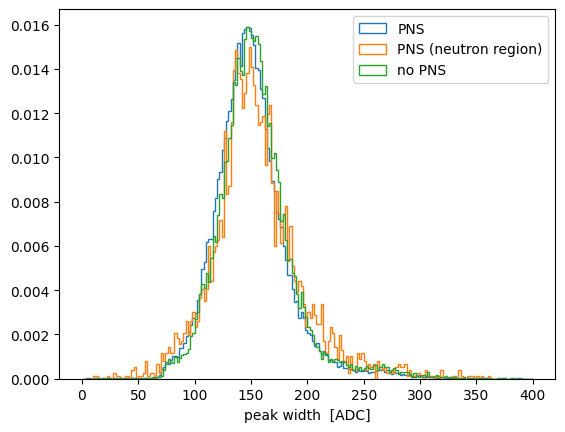

In [9]:
norm = True
range = (0, 400)
plt.hist(flatten_property(n_peaks, 'widths'), bins = 200, histtype='step', label='PNS', range = range, density=norm);
plt.hist(flatten_property(sn_peaks, 'widths'), bins = 200, histtype='step', label='PNS (neutron region)', range = range, density=norm);
plt.hist(flatten_property(c_peaks, 'widths'), bins = 200, histtype='step', label='no PNS', range = range, density=norm);
plt.xlabel('peak width  [ADC]')
plt.legend();

In [10]:
def intergrals(data, peaks):
    properties = peaks['properties']
    integrals = []
    for trigger_idx in np.arange(0, data.shape[0], 1):
        for i in np.arange(0, len(properties[trigger_idx]['left_ips']), 1):
            l = int(np.ceil(properties[trigger_idx]['left_ips'][i]))
            r = int(np.ceil(properties[trigger_idx]['right_ips'][i]))
            I = np.sum(data[trigger_idx, l:r])
            integrals.append(I)
    return np.array(integrals)

In [11]:
n_integrals = intergrals(n_data, n_peaks)
sn_integrals = intergrals(sn_data, sn_peaks)
c_integrals = intergrals(c_data, c_peaks)

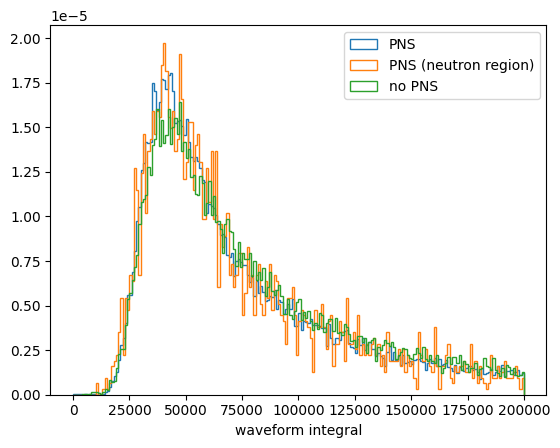

In [12]:
norm = True
range = (0, 200000)
plt.hist(n_integrals, bins = 200, histtype='step', label='PNS', range = range, density=norm);
plt.hist(sn_integrals, bins= 200, histtype='step', label='PNS (neutron region)', range = range, density=norm);
plt.hist(c_integrals, bins = 200, histtype='step', label='no PNS', range = range, density=norm);
plt.xlabel('waveform integral')
plt.legend();

In [13]:
def promptFraction(data, peaks, prompt_right_boundary=30):
    properties = peaks['properties']
    integrals, PF = [], []
    for trigger_idx in np.arange(0, data.shape[0], 1):
        for i in np.arange(0, len(properties[trigger_idx]['left_ips']), 1):
            l = int(np.ceil(properties[trigger_idx]['left_ips'][i]))
            r = int(np.ceil(properties[trigger_idx]['right_ips'][i]))
            rprompt = int(np.ceil(properties[trigger_idx]['left_ips'][i])+prompt_right_boundary)
            P = np.sum(data[trigger_idx, l:rprompt])
            I = np.sum(data[trigger_idx, l:r])
            PF.append(P/I)
            integrals.append(I)
    return np.array(PF), np.array(integrals)



In [14]:
prompt_boundary=50
n_PF, n_I = promptFraction(n_data, n_peaks, prompt_right_boundary=prompt_boundary)
gn_PF, gn_I = promptFraction(sn_data, sn_peaks, prompt_right_boundary=prompt_boundary)
c_PF, c_I = promptFraction(c_data, c_peaks, prompt_right_boundary=prompt_boundary)

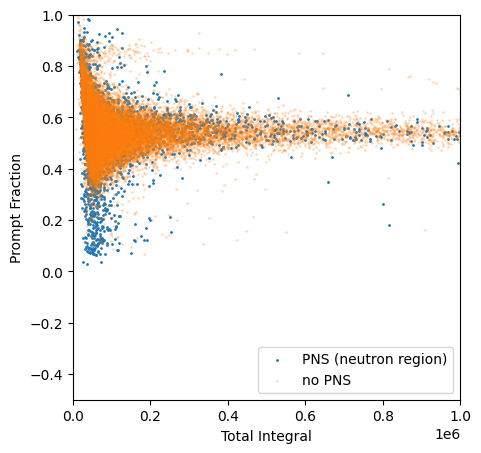

In [15]:
fig, axs= plt.subplots(1, 1, figsize=[5, 5]) 
ax = axs
# ax.scatter(n_I, n_PF,  s=1, label='PNS')
ax.scatter(gn_I, gn_PF,  s=1, label='PNS (neutron region)')
ax.scatter(c_I, c_PF,  s=1, label='no PNS', alpha=0.2)
ax.set_ylim(-0.5, 1)
# ax.set_xlim(0, 0.6e7)
ax.set_xlim(0, 1.e6)
ax.set_ylabel('Prompt Fraction')
ax.set_xlabel('Total Integral')
ax.legend(loc='lower right');

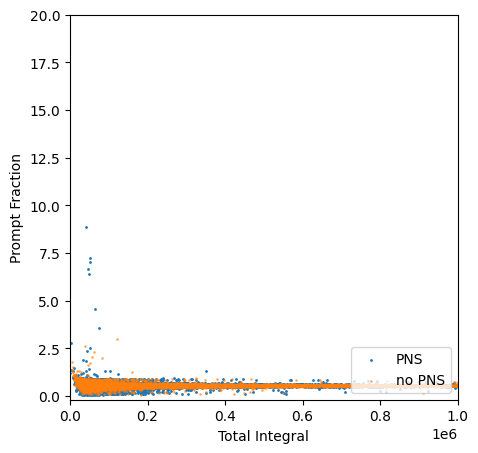

In [16]:
fig, axs= plt.subplots(1, 1, figsize=[5, 5]) 
ax = axs
ax.scatter(n_I, n_PF,  s=1, label='PNS')
# ax.scatter(gn_I, gn_PF,  s=1, label='PNS (neutron region)')
ax.scatter(c_I, c_PF,  s=1, label='no PNS', alpha=0.5)
ax.set_ylim(-0.2, 20)
# ax.set_xlim(0, 0.6e7)
ax.set_xlim(0, 1.e6)
ax.set_ylabel('Prompt Fraction')
ax.set_xlabel('Total Integral')
ax.legend(loc='lower right');

In [17]:
def promptFraction_noSat(data, peaks, prompt_right_boundary=30):
    properties = peaks['properties']
    integrals, PF = [], []
    for trigger_idx in np.arange(0, data.shape[0], 1):
        for i in np.arange(0, len(properties[trigger_idx]['left_ips']), 1):
            if properties[trigger_idx]['plateau_sizes'][i] < 2:
                l = int(np.ceil(properties[trigger_idx]['left_ips'][i]))
                r = int(np.ceil(properties[trigger_idx]['right_ips'][i]))
                rprompt = int(np.ceil(properties[trigger_idx]['left_ips'][i])+prompt_right_boundary)
                P = np.sum(data[trigger_idx, l:rprompt])
                I = np.sum(data[trigger_idx, l:r])
                PF.append(P/I)
                integrals.append(I)
    return np.array(PF), np.array(integrals)

In [18]:
prompt_boundary=50
n_PF, n_I = promptFraction_noSat(n_data, n_peaks, prompt_right_boundary=prompt_boundary)
gn_PF, gn_I = promptFraction_noSat(sn_data, sn_peaks, prompt_right_boundary=prompt_boundary)
c_PF, c_I = promptFraction_noSat(c_data, c_peaks, prompt_right_boundary=prompt_boundary)

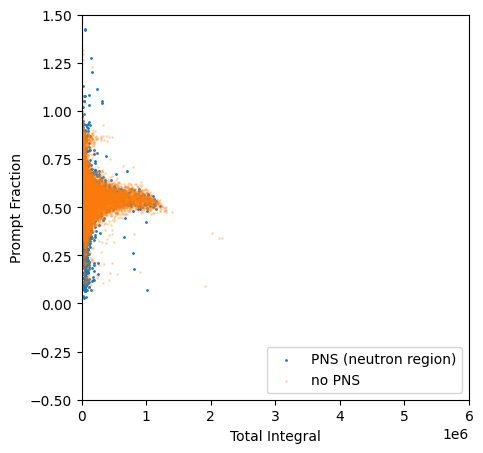

In [19]:
fig, axs= plt.subplots(1, 1, figsize=[5, 5]) 
ax = axs
# ax.scatter(n_I, n_PF,  s=1, label='PNS')
ax.scatter(gn_I, gn_PF,  s=1, label='PNS (neutron region)')
ax.scatter(c_I, c_PF,  s=1, label='no PNS', alpha=0.2)
ax.set_ylim(-0.5, 1.5)
ax.set_xlim(0, 0.6e7)
ax.set_ylabel('Prompt Fraction')
ax.set_xlabel('Total Integral')
ax.legend(loc='lower right');

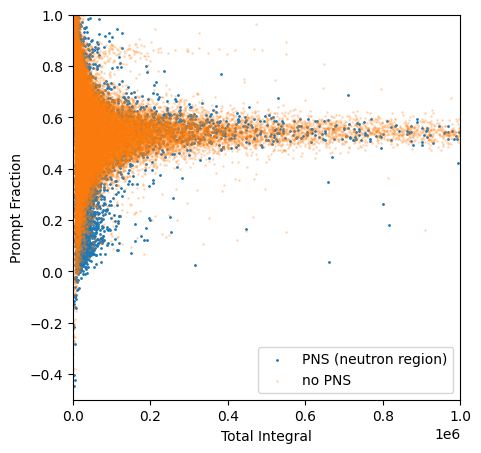

In [28]:
fig, axs= plt.subplots(1, 1, figsize=[5, 5]) 
ax = axs
# ax.scatter(n_I, n_PF,  s=1, label='PNS')
ax.scatter(gn_I, gn_PF,  s=1, label='PNS (neutron region)')
ax.scatter(c_I, c_PF,  s=1, label='no PNS', alpha=0.2)
ax.set_ylim(-0.5, 1)
# ax.set_xlim(0, 0.6e7)
ax.set_xlim(0, 1.e6)
ax.set_ylabel('Prompt Fraction')
ax.set_xlabel('Total Integral')
ax.legend(loc='lower right');